In [1]:
import math, glob, time, os, re, json
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

In [2]:
def normalized_histogram(data, bins):
    weights = np.ones_like(data) / len(data)
    return np.histogram(data, bins, weights = weights)

plt.rcParams.update({'font.size': 22})

In [3]:
moves_data = pd.read_csv('moves-20b.csv.gz',index_col=0)
games_data = pd.read_csv('games-20b.csv.gz',index_col=0)
print(f"Loaded {games_data.shape[0]} games and {moves_data.shape[0]} moves.")

Loaded 2186 games and 592515 moves.


In [4]:
user_moves = moves_data[moves_data.move_color==moves_data.user_color].copy()

In [5]:
def make_features(df):
    pol_rank_frac, _bins = normalized_histogram(df.policy_rank.values,bins=[-0.5,0.5,3.5,9.5,19.5,39.5,79.5])
#    pol_loss_frac, _bins = normalized_histogram(df.top_value - df.policy_value,bins=np.arange(-0.025,0.975,0.05)) #??
    score_loss, _bins = normalized_histogram(df.points_lost.clip(-6,50),bins=[-6,-1.5,-0.5,0.5,1.5,3,6,12,25,50])
    
    f =  {f"{k}.{i}":v for k,l in {'policy_rank_hist':pol_rank_frac,
                       #'policy_loss_hist':pol_loss_frac,
                       'score_loss_hist':score_loss}.items() for i,v in enumerate(l) }
    return f

In [28]:
x = []
y = []
x_game_id = []
for game_id,df in user_moves.groupby('game_id'):
    x_game_id.append(game_id)
    x.append(make_features(df))
    y.append( games_data.loc[game_id,'user_rank'] )

In [29]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

df = pd.DataFrame(x)
y=np.array(y)
x=df.values
xN = ss.fit_transform(x)
x_game_id=np.array(x_game_id)
df

,policy_rank_hist.0,policy_rank_hist.1,policy_rank_hist.2,policy_rank_hist.3,policy_rank_hist.4,policy_rank_hist.5,score_loss_hist.0,score_loss_hist.1,score_loss_hist.2,score_loss_hist.3,score_loss_hist.4,score_loss_hist.5,score_loss_hist.6,score_loss_hist.7,score_loss_hist.8
0,0.294118,0.264706,0.127451,0.098039,0.098039,0.098039,0.049020,0.088235,0.274510,0.196078,0.039216,0.147059,0.196078,0.009804,0.000000
1,0.367347,0.272109,0.183673,0.081633,0.040816,0.034014,0.088435,0.170068,0.312925,0.102041,0.102041,0.088435,0.095238,0.040816,0.000000
2,0.355030,0.213018,0.142012,0.100592,0.100592,0.071006,0.153846,0.153846,0.272189,0.142012,0.106509,0.088757,0.041420,0.035503,0.005917
3,0.232759,0.232759,0.155172,0.103448,0.086207,0.146552,0.137931,0.068966,0.215517,0.129310,0.086207,0.112069,0.120690,0.112069,0.017241
4,0.107383,0.281879,0.194631,0.120805,0.100671,0.114094,0.040268,0.046980,0.288591,0.228188,0.140940,0.107383,0.087248,0.040268,0.020134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2181,0.252174,0.191304,0.147826,0.104348,0.095652,0.095652,0.052174,0.130435,0.260870,0.165217,0.139130,0.182609,0.069565,0.000000,0.000000
2182,0.317460,0.301587,0.206349,0.031746,0.063492,0.047619,0.063492,0.047619,0.349206,0.158730,0.174603,0.174603,0.031746,0.000000,0.000000
2183,0.383459,0.240602,0.203008,0.082707,0.060150,0.030075,0.007519,0.022556,0.300752,0.360902,0.210526,0.090226,0.000000,0.007519,0.000000
2184,0.090909,0.118881,0.216783,0.153846,0.146853,0.139860,0.104895,0.062937,0.097902,0.132867,0.230769,0.181818,0.111888,0.062937,0.013986


In [30]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
model = Sequential()
model.add(Dense(20, input_dim=15, activation='tanh', kernel_regularizer='l2'))
model.add(Dense(10, activation='tanh', kernel_regularizer='l2'))
model.add(Dense(1, activation=None))
model.compile(loss='mse', optimizer='adam')

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(xN, y, epochs=100, batch_size=16,verbose=0,
                    validation_split=0.1,callbacks=[TQDMNotebookCallback(),es])


Epoch 00071: early stopping


(15.0, 50.0)

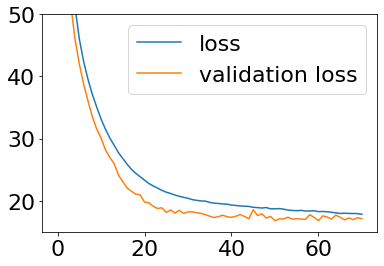

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']); plt.legend(['loss','validation loss'])
plt.ylim([15,50])

Text(0, 0.5, 'Predicted Rank')

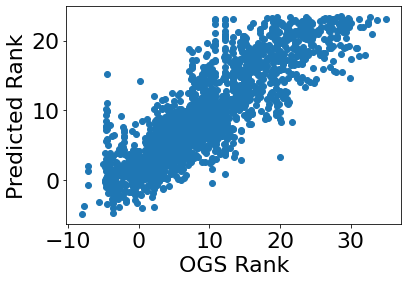

In [33]:
pY = model.predict(xN)[:,0]
plt.scatter(y,pY)
plt.xlabel('OGS Rank')
plt.ylabel('Predicted Rank')

In [ ]:
games_data.loc[x_game_id[(y < 0) & (pY > 10)]]

In [ ]:
han = games_data[games_data.user=='argen1204'].index

In [ ]:
sorted([b for a,b,c in zip(y,pY,x_game_id) if c in han])

In [ ]:
games_data.user

array([[ 6.74583416,  3.63277197],
       [ 3.62596742,  3.22109127],
       [ 8.85532346,  4.94409657],
       ...,
       [-2.63712548,  3.7717061 ],
       [ 8.4050053 , 18.85416794],
       [-2.45982388,  5.05369949]])

In [ ]:
from scipy.stats import kde
nbins=300
k = kde.gaussian_kde(np.array([y,pY]).transpose())
xi, yi = np.mgrid[-10:30:nbins*1j, -10:30:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.magma)
plt.plot([-10, 30], [-10, 30], linewidth=0.5, c='m')

In [42]:
k


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde


# load the output of analyze_rank.py, which has different row lengths
textfile = open("quality-est.csv", "r")
listr = textfile.readlines()
textfile.close()
data = np.empty((len(listr)-1,30,))
data[:] = np.nan

i = 0
for line in listr:
    if i>0: #do not read first line
        lstr = line.strip().split(",")[1:]
        data[i-1, :len(lstr)] = np.array([float(v) for v in lstr])[:30]
    i+=1

In [25]:
data

array([[-1.937648, -0.27171 ,  4.81266 , ...,  1.79714 , 28.71135 ,
              nan],
       [ 1.674333,  1.47947 ,  3.76166 , ...,       nan,       nan,
              nan],
       [-2.159611, -0.82683 , -1.76082 , ...,       nan,       nan,
              nan],
       ...,
       [-3.325081, -1.48551 ,  4.34426 , ...,       nan,       nan,
              nan],
       [-3.046517,  0.88152 ,  0.50762 , ...,       nan,       nan,
              nan],
       [-0.685923,  2.24257 ,  4.81266 , ...,       nan,       nan,
              nan]])

<Figure size 432x288 with 0 Axes>

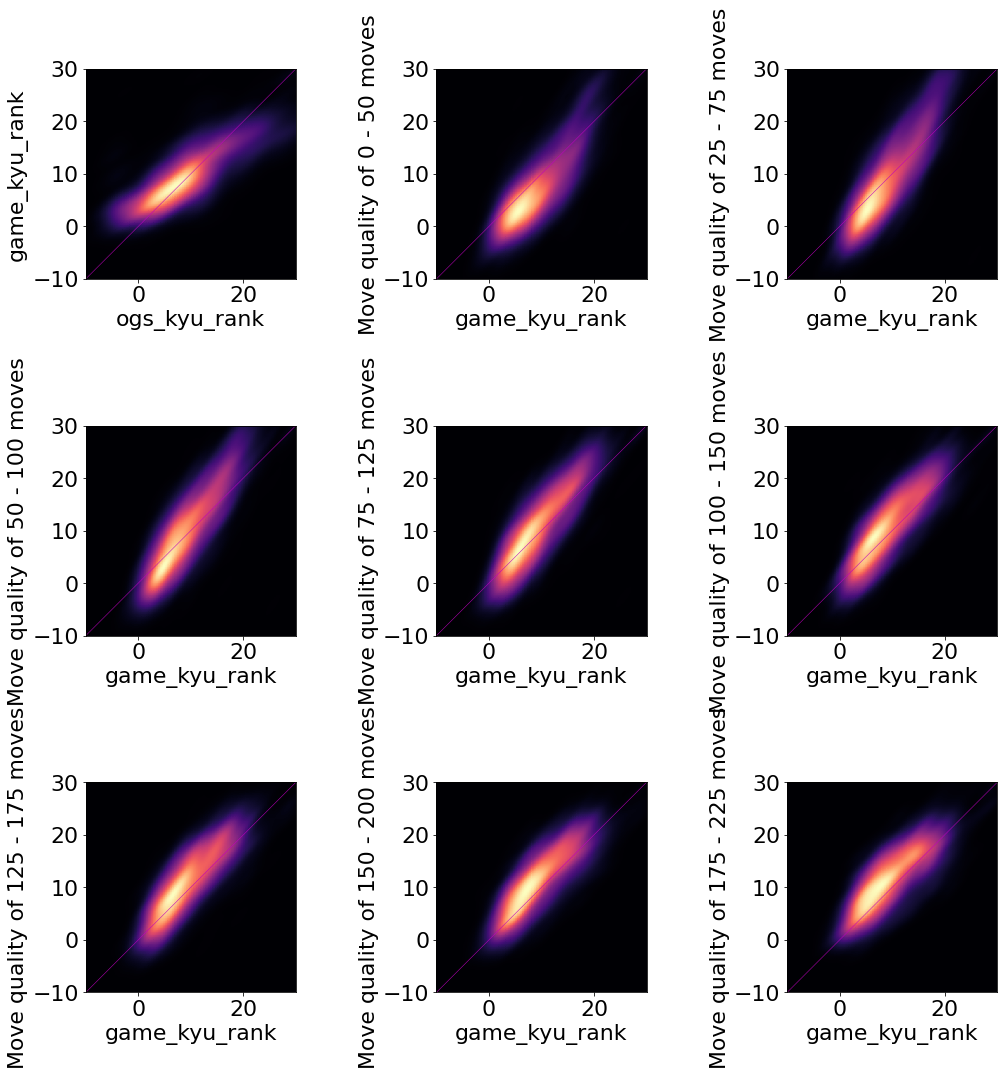

In [43]:
fig = plt.figure()
_, axs = plt.subplots(3,3,figsize=(15,15))

xy = [[0, 2], [2, 4], [2, 6], [2, 8], [2, 10], [2, 12], [2, 14], [2, 16], [2, 18]]
coord = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
label = [["ogs_kyu_rank", "game_kyu_rank"],["game_kyu_rank", "Move quality of 0 - 50 moves"],["game_kyu_rank", "Move quality of 25 - 75 moves"],["game_kyu_rank", "Move quality of 50 - 100 moves"],["game_kyu_rank", "Move quality of 75 - 125 moves"],["game_kyu_rank", "Move quality of 100 - 150 moves"],["game_kyu_rank", "Move quality of 125 - 175 moves"] ,["game_kyu_rank", "Move quality of 150 - 200 moves"],["game_kyu_rank", "Move quality of 175 - 225 moves"]]

i = 0
for xyel in xy:

    x = xyel[0]
    y = xyel[1]
    plo = data[:, [x, y]][~np.isnan(data[:, [x, y]]).any(axis=1)]
    
    
    nbins=300
    k = kde.gaussian_kde([plo[:, 0],plo[:, 1]])
    xi, yi = np.mgrid[-10:30:nbins*1j, -10:30:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    axs[coord[i][0]][coord[i][1]].set_aspect('equal', adjustable='box')
    axs[coord[i][0]][coord[i][1]].set_xlim(-10, 30)
    axs[coord[i][0]][coord[i][1]].set_ylim(-10, 30)
    axs[coord[i][0]][coord[i][1]].set_xlabel(label[i][0])
    axs[coord[i][0]][coord[i][1]].set_ylabel(label[i][1])
    axs[coord[i][0]][coord[i][1]].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.magma)
    axs[coord[i][0]][coord[i][1]].plot([-10, 30], [-10, 30], linewidth=0.5, c='m')
    i+=1



plt.tight_layout()
plt.show()

In [44]:
[plo[:, 0],plo[:, 1]]

[array([ 4.81266, -1.76082, 11.66893, ...,  5.14184,  4.34426,  4.81266]),
 array([ 3.76166, -0.67233, 16.5278 , ..., 12.07822,  3.90316, 10.55913])]